# Global Wheat Detection
## Problem Overview:

Open up your pantry and you’re likely to find several wheat products. Indeed, your morning toast or cereal may rely upon this common grain. Its popularity as a food and crop makes wheat widely studied. To get large and accurate data about wheat fields worldwide, plant scientists use image detection of "wheat heads"—spikes atop the plant containing grain. These images are used to estimate the density and size of wheat heads in different varieties. Farmers can use the data to assess health and maturity when making management decisions in their fields.

However, accurate wheat head detection in outdoor field images can be visually challenging. There is often overlap of dense wheat plants, and the wind can blur the photographs. Both make it difficult to identify single heads. Additionally, appearances vary due to maturity, color, genotype, and head orientation. Finally, because wheat is grown worldwide, different varieties, planting densities, patterns, and field conditions must be considered. Models developed for wheat phenotyping need to generalize between different growing environments. Current detection methods involve one- and two-stage detectors (Yolo-V3 and Faster-RCNN), but even when trained with a large dataset, a bias to the training region remains.

The Global Wheat Head Dataset is led by nine research institutes from seven countries: the University of Tokyo, Institut national de recherche pour l’agriculture, l’alimentation et l’environnement, Arvalis, ETHZ, University of Saskatchewan, University of Queensland, Nanjing Agricultural University, and Rothamsted Research. These institutions are joined by many in their pursuit of accurate wheat head detection, including the Global Institute for Food Security, DigitAg, Kubota, and Hiphen.

In this competition, you’ll detect wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe. Using worldwide data, you will focus on a generalized solution to estimate the number and size of wheat heads. To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. You will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.

Wheat is a staple across the globe, which is why this competition must account for different growing conditions. Models developed for wheat phenotyping need to be able to generalize between environments. If successful, researchers can accurately estimate the density and size of wheat heads in different varieties. With improved detection farmers can better assess their crops, ultimately bringing cereal, toast, and other favorite dishes to your table. 

# Data
More details on the data acquisition and processes are available at https://www.kaggle.com/c/global-wheat-detection/data

Data Format: The data is images of wheat fields, with bounding boxes for each identified wheat head. Not all images include wheat heads / bounding boxes. The images were recorded in many locations around the world.

The CSV data is simple - the image ID matches up with the filename of a given image, and the width and height of the image are included, along with a bounding box. There is a row in train.csv for each bounding box. Not all images have bounding boxes.

**Goal:** The goal is to predict bounding boxes around each wheat head in images that have them. If there are no wheat heads, you must predict no bounding boxes.

**File Structure:**

* train.csv - the training data
* sample_submission.csv - a sample submission file in the correct format
* train.zip - training images
* test.zip - test images

**Fields in csv:**

* image_id - the unique image ID
* width, height - the width and height of the images
* bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height].

## Posing this as a Deep Learning porblem.

* We have images and their corresponding bounding boxes in the data.
* Given these 2 as input to the model we need to precit the bounding boxes around each wheat head in a given image from the test data.
* This prediction involves object detection in the images and plotting bounding boxes around it.
* we can use techniques like Faster RCNN or Yolo v3 to do these tasks.


## Metics:

* This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds. The IoU of a set of predicted bounding boxes and ground truth bounding boxes is calculated as:
                           
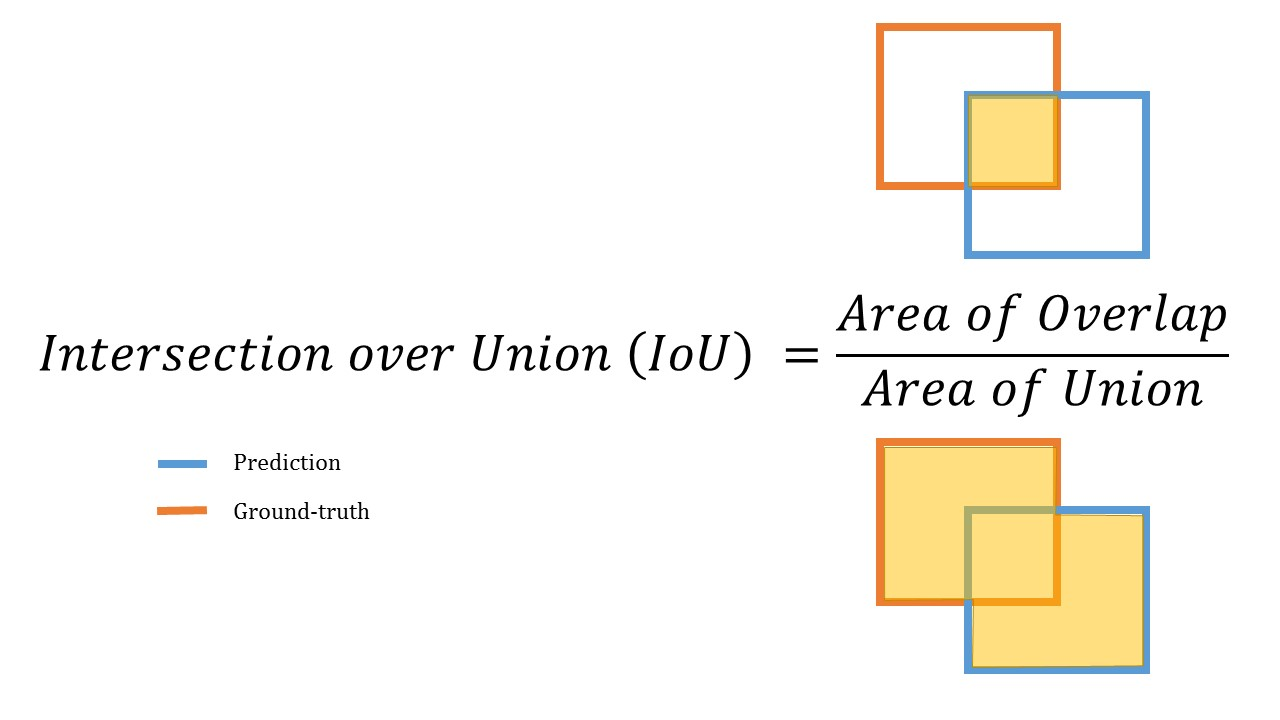

In [ ]:
import os
import pandas as pd
import numpy as np

from glob import glob
from PIL import Image
import cv2

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs

# import data augmentation
import albumentations as albu
from ast import literal_eval


## Set up Paths

In [ ]:
TRAIN_DIR = '../input/global-wheat-detection/train/'
TEST_DIR = '../input/global-wheat-detection/test/'
TRAIN_CSV_PATH = '../input/global-wheat-detection/train.csv'

# Glob the directories and get the lists of train and test images
train_path = glob(TRAIN_DIR + '*')
test_path = glob(TEST_DIR + '*')


print('Number of train images are :', len(os.listdir(TRAIN_DIR)))
print('Number of test  images are :', len(os.listdir(TEST_DIR)))

* We only have 10 test images and those are very low. 
* we have 3422 train images which are low as well for training a deep neural network model so data augmentation and transfer learning techniques will sure come in handy a lot.

## Constructing Dataframe

In [ ]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
print(train_df.head(5))
print('\n')
print('Number of rows are ',train_df.shape[0])

* Each row cosists of an image id, shape of image,Bbox and source details
* Bbox details are given in a list of elements, so we need to seperate them in diffenret columns for better use.
* Have to do sanity check on image shapes and then have to see how many images given per source and observe how the images changes according to the source.
* There are total of 147793 rows, which implies that each images contains multiple bounding boxes as we olny have 3422 images in total.

## Basic Check 

In [ ]:
def grader_1(train_df):
    if (train_df['width'].unique() == train_df['height'].unique() == [1024]):
        print('All train images given are of shape 1024x1024')
    else:
        print('Not all train images are of same shape')
grader_1(train_df)

## Sorting dataframe by images and splitting Bbox

In [ ]:
all_train_images = pd.DataFrame([i.split('/')[-1][:-4] for i in train_path])
all_train_images.columns=['image_id']

#Merging on image_id column to get sorted list of images_id according to the images that we have in the path directory.
all_train_images = all_train_images.merge(train_df, on='image_id', how='left')

# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

# split bbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

print(all_train_images.head)

In [ ]:
all_train_images.columns

* We made a dataframe wiht the imageid that we have in the train directory.
* Then we made this dataframe merge on the dataframe we loaded and then merged on image id so that we get an image and followed by its bounding boxes in a ordered fashion instead of random.
* I filled bbox column with [0,0,0,0] where there is no bbox.

## Check for no Bbox 

In [ ]:
print('{} images without wheat heads.'.format(len(all_train_images) - len(train_df)))

There are 49 images where there are no bouding boxes present in the given data of images.

## Adding Bbox area column 

In [ ]:
def get_bbox_area(bbox):
    bbox = literal_eval(bbox)
    return bbox[2] * bbox[3]

all_train_images['bbox_area'] = all_train_images['bbox'].apply(get_bbox_area)
all_train_images = all_train_images.drop(['bbox'],axis=1)

In [ ]:
plt.hist(all_train_images['bbox_area'].value_counts(), bins=30)
plt.title('Histogram for Bbox area feature')
plt.xlabel('Bounding boxes')
plt.ylabel('Area')
plt.show()

As organizers say, there are many bounding boxes for each image, and not all images include wheat heads / bounding boxes.

In [ ]:
all_train_images.bbox_area.max()

* Maximum are of a bounding box is 529788.
* The distribution of individual areas of bounding boxes has a very long tail. It would be interesting to look at the images with those large bounding boxes.

## Calculating Average bbox area based on source

In [ ]:
Avg_df = all_train_images.groupby('source',as_index=False)['bbox_area'].mean()
print(Avg_df)

In [ ]:
plt.bar(Avg_df['source'],Avg_df['bbox_area'],align='center')
plt.title('Bar plot for avg Bbox area feature')
plt.xlabel('Source')
plt.ylabel('Avg Area')
plt.show()

* Source named inrae_1 images are having most avergae bounding bix area. so we may intrepert that the images from this source might have more wheat heads and eventually more bboxes.
* There is no clear speratability in average bounding boxes. so most of them have almost same average bounding box ares.

## EDA on source of the images

In [ ]:
#Reference : https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

counts = dict(all_train_images.source.value_counts())
fig,ax = plt.subplots(figsize=(8,8))

wedges, texts, autotexts = ax.pie(list(counts.values()), autopct='%1.1f%%',shadow=True, startangle=90);
ax.legend(wedges, list(counts.keys()),
          title="Sources",
          loc="center",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=15);

ax.set_title("Data Distribution based on Sources");
plt.show();
sns.countplot(x='source', data=all_train_images);


* I noticed that images came from differnet sources and each source contributed differnet amout of images for the training.
* Most of the images are produced by arvalis_1 source followed by ethz_1.
* We should not call this as imbalanced right as above bar graph indicated sources of the images but not the class labels.
* Total 7 sources out of which 3 are minority and 4 are majority

## Analysing bounding boxes per image

In [ ]:
uniqueimages = all_train_images['image_id'].unique()
print('Number of unique images are ', len(uniqueimages))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)


fig.set_size_inches(16,5)
ax1.hist(all_train_images['image_id'].value_counts(), bins=30)
ax1.set_title('Number of spikes per image')
ax1.set_xlabel('Bounding boxes')
ax1.set_ylabel('Images')


#values = unique_categories[unique_categories.unique_values <= 25].unique_values
ax2.set_xlim(112,118)
ax2.set_ylim(0,10)
ax2.hist(all_train_images['image_id'].value_counts(), bins=30)
ax2.set_title('Zooming left part of histogram')
ax2.set_xlabel('Bounding boxes')
ax2.set_ylabel('Images')
ax2.grid(True)

* Max number of bounding boxes is 116, whereas min (annotated) number is 1.
* Most of the images have 20-50 wheat spikes on them.
* There are very few images with more than 80 bouinding boxes per image.

## Plotting some Images with bouding boxes

In [ ]:
def get_all_bboxes(df,image_id):
    image_boxes = df[df['image_id'] == image_id]
    bboxes = []
    for _,row in image_boxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
    return bboxes

def plot_random_image(df,rows = 3,cols = 3):
    fig,ax = plt.subplots(rows,cols,figsize=(12,12))
    for row in range(rows):
        for col in range(cols):
            index = np.random.randint(len(df),size=1)[0]
            img_id = df.iloc[index].image_id
            img = Image.open(TRAIN_DIR + img_id + '.jpg')
            ax[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for box in bboxes:
                add_box = patches.Rectangle((box[0],box[1]),box[2],box[3],linewidth=1,edgecolor='r',facecolor='none')
                ax[row, col].add_patch(add_box)
            
            ax[row, col].axis('off')

In [ ]:
plot_random_image(all_train_images)

* Observed that there are numerous amount of bounding boxes per image.
* And there are some images with fewer number of bounding boxes. 
* I think its best to see maximum and minimum number of bounding boxes in the given data.
* Images are of different kinds, i think images that came from a source are alike and other sources ae of diffent kind of images.
* We can see images taken at different lighting conditions and plant maturity stages!

## Visualising images by their source

In [ ]:
plot_random_image(all_train_images[all_train_images.source == 'ethz_1'])

* Most of the images from this source conatin more number of bounding boxes per image.
* Density of wheat heads are more in this source of images.
* Images have dark green color shit mostly.

In [ ]:
plot_random_image(all_train_images[all_train_images.source == 'arvalis_3'])

* Images have very low bounding boes to high bounding boxes count.
* Some images have a lot of background data compared to wheat heads.
* Images might be taken in different ligh conditions.

In [ ]:
plot_random_image(all_train_images[all_train_images.source == 'usask_1'])

* Images have very low bounding boes to high bounding boxes count.
* Some images have a lot of background data compared to wheat heads.
* Images might be taken in different ligh conditions.
* Images contain mostly leaves instead of wheat heads. so this might be an indication on these are overgrown plants may be??

In [ ]:
plot_random_image(all_train_images[all_train_images.source == 'rres_1'])

* Color of the leaves showcase yellow tint rather than green.
* Avergae number of boudning boxes. 
* Mostly taken in dark lighting conitions.

In [ ]:
plot_random_image(all_train_images[all_train_images.source == 'arvalis_1'])

* Images look so bright.
* Most of the images are taken in bright day light conditions.
* Images have average to more bounding boxes. so its good.
* Most images have green adn brown tint.

In [ ]:
plot_random_image(all_train_images[all_train_images.source == 'inrae_1'])

* Some of the wheat heads are longer than remaining images.
* So big boundign boxes are found.
* Images are taken in decent light conditons.
* Dark Green tint can eb found across the images.

In [ ]:
plot_random_image(all_train_images[all_train_images.source == 'arvalis_2'])

* Images are taken in brighter conditions.
* less wheat heads compared to other stuff in the images.
* Wheat heads are almost same color as leaves...so it might be harder to detect a litle bit.

## Visualising images with no bounding boxes and source

In [ ]:
all_train_images['source'] = all_train_images['source'].fillna('No source')
all_train_images.source.unique()

print('No of images with no boxes are ',all_train_images[all_train_images['source']=='No source'].shape[0])

In [ ]:
plot_random_image(all_train_images[all_train_images['source']=='No source']);

* Observed that there are images with no bounding boxes present in it.
* We can label them as no box labels when we are modelling.
* Total 49 of that kind of images are present in the data.

## Lets visualize images based on size of bounding boxes

In [ ]:
large_boxes_ids = all_train_images[all_train_images['bbox_area'] > 200000].image_id
plot_random_image(all_train_images[all_train_images.image_id.isin(large_boxes_ids)])

* We can see there are huge bouidng boxes in the images, but those boxes contain little to no wheat heads.

In [ ]:
small_boxes_ids = all_train_images[(all_train_images['bbox_area'] < 50) & (all_train_images['bbox_area'] > 0)].image_id
plot_random_image(all_train_images[all_train_images.image_id.isin(small_boxes_ids)])

* If you look very close, you can probably see those tinyest bounding boxes near the corners and borders of the images. Probably, the boundries were drawn first, than the images were cut into several ones. That is why we see those strange small bounsing boxes in the corners.

* It is not necessary to clean these, because they won't have much effect on the IOU metric.

## Observations from the above analysis

* It is evident from the above image analysis that each type of source has specific types of wheat images. This is probably dependent on the region of data collection and time of the year when the particular data was collected.
* There are some images with no bounding boxes at all.
* Count of bounding boxes will vary from a min of 1 to max of 116.
* Most of the images conatin an average of 20 to 60 bounding boxes.
* Images given are taken from different lighting conditions at differen plant growth level.
* Bounding boxes are messy!
1. Giant bounding boxes should be filtered out by area and removed before model training.
1. Micro bounding boxes. These can stay. They won't have much effect on the IOU metric.
1. Some spikes are not surrounded by a bounding box (missing bounding boxes).

## Possible Approaches for Prediction

* We can directly create an object detection neural network for this problem. But it would try to find wheat in every picture even if it doesn't have any. This might result in false positives.
* Another approach is to create a classification + object detection ensemble model which would first classify whether the image has any wheat or not. The images that are classified as having wheats will be passed to the object detector for bounding box detection. This would reduce the problem of false positives but might lead to some false negatives